### GRU
- 게이트 메커니즘이 적용된 RNN 프레임워크의 일종으로 LSTM보다 더 간략한 구조


### LSTM이 아닌 GRU Model 선택 이유

- **각 주식별 모델링**을 해야하기 때문에 **파라미터 수가 적어 학습시간이 더 짧게 걸리는 `GRU`**를 선택
- **일별 데이터**이기 때문에 **소량의 데이터에서 학습이 우수한 `GRU`**를 선택

In [1]:
import tensorflow as tf

# GPU 확인
tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None )

True

In [59]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from dateutil.parser import parse

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [60]:
print(tf.__version__)

print(tf.keras.__version__)

print(pd.__version__)

2.0.0
2.2.4-tf
1.0.1


In [153]:
# 파일 불러오기 예시
# pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')

# 4319
data = pd.read_csv('result.csv', encoding='cp949').set_index('date')
print(data.shape)
data.head(2)

(1501, 31)


,아시아종묘,조비,효성오앤비,경농,남해화학,KG케미칼,농우바이오,성보화학,아세아텍,동방아그로,...,green_onion,cucumber,price_egg,price_milk,price_sugar,exchangerate,kospi,Dubai,Brent,WTI
date,,,,,,,,,,,,,,,,,,,,,
2014-08-01,3300.0,12000.0,17300.0,5780.0,9260.0,13700.0,20650.0,42350.0,3455.0,6380.0,...,1156.0,62722.0,5987.0,2549.0,435.7,1037.75,2073.10,104.92,104.84,97.88
2014-08-04,3300.0,12000.0,17350.0,5900.0,9280.0,13700.0,21100.0,43050.0,3465.0,6370.0,...,1510.0,43128.0,5987.0,2549.0,468.9,1033.35,2080.42,103.15,105.41,98.29


In [154]:
data.loc[str(parse(data.index[-1]).date() + timedelta(days=1))] = [np.nan for _ in range(data.shape[1])]

In [155]:
data.tail(2)

,아시아종묘,조비,효성오앤비,경농,남해화학,KG케미칼,농우바이오,성보화학,아세아텍,동방아그로,...,green_onion,cucumber,price_egg,price_milk,price_sugar,exchangerate,kospi,Dubai,Brent,WTI
date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,3750.0,12350.0,5400.0,9580.0,6990.0,10850.0,8800.0,3300.0,3590.0,5400.0,...,844.0,43002.0,5311.0,2623.0,330.9,1218.8,1754.64,23.43,22.74,20.48
2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
target_name = 'KG케미칼'
target_names = [target_name, 'Brent']
#df = data[]
shift_steps = 1

df = data[target_names].shift(1)

df.tail(3)

,KG케미칼,Brent
date,,
2020-03-30,9370.0,24.93
2020-03-31,9400.0,22.76
2020-04-01,10850.0,22.74


In [173]:
df_targets = df[target_name].shift(-shift_steps)
# df_targets = df.shift(-shift_steps)

df_targets.tail(3)

date
2020-03-30     9400.0
2020-03-31    10850.0
2020-04-01        NaN
Name: KG케미칼, dtype: float64

In [174]:
df.index[-65:]

Index(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07', '2020-01-08',
       '2020-01-09', '2020-01-10', '2020-01-13', '2020-01-14', '2020-01-15',
       '2020-01-16', '2020-01-17', '2020-01-20', '2020-01-21', '2020-01-22',
       '2020-01-23', '2020-01-24', '2020-01-27', '2020-01-28', '2020-01-29',
       '2020-01-30', '2020-01-31', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-10', '2020-02-11', '2020-02-12',
       '2020-02-13', '2020-02-14', '2020-02-17', '2020-02-18', '2020-02-19',
       '2020-02-20', '2020-02-21', '2020-02-24', '2020-02-25', '2020-02-26',
       '2020-02-27', '2020-02-28', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-09', '2020-03-10', '2020-03-11',
       '2020-03-12', '2020-03-13', '2020-03-16', '2020-03-17', '2020-03-18',
       '2020-03-19', '2020-03-20', '2020-03-23', '2020-03-24', '2020-03-25',
       '2020-03-26', '2020-03-27', '2020-03-30', '2020-03-31', '2020-04-01']

In [175]:
x_data = df.values[shift_steps:-23] # 3월 예측

print(type(x_data))
print("Shape:", x_data.shape)
y_data = df_targets.values[shift_steps:-23].reshape(-1,1)

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (1478, 2)
<class 'numpy.ndarray'>
Shape: (1478, 1)


In [176]:
num_data = len(x_data)
print(num_data)
train_split = 0.9

num_train = int(train_split * num_data)
print(num_train)

num_test = num_data - num_train
print(num_test)

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(len(x_train) + len(x_test))

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(len(y_train) + len(y_test))

1478
1330
148
1478
1478


In [177]:
# input 갯수
num_x_signals = x_data.shape[1]
# output 갯수
num_y_signals = y_data.shape[1]

print('input ouput 갯수 :',num_x_signals, num_y_signals)

input ouput 갯수 : 2 1


In [178]:
# Scaled Data
x_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
# print("Min:", np.min(x_train_scaled))
# print("Max:", np.max(x_train_scaled))

In [179]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [180]:
batch_size = 256
sequence_length = 365
warmup_steps = 100

generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(256, 365, 2)
(256, 365, 1)


In [181]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [182]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

def init_model():
    model = Sequential()

    model.add(GRU(units=512,
                  return_sequences=True,
                  input_shape=(None, num_x_signals,)))

    model.add(Dense(num_y_signals, activation='sigmoid'))

    optimizer = RMSprop(lr=1e-3)

    model.compile(loss=loss_mse_warmup, optimizer=optimizer)

    model.summary()

    return model

model = init_model()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, None, 512)         792576    
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           513       
Total params: 793,089
Trainable params: 793,089
Non-trainable params: 0
_________________________________________________________________


In [183]:
model

In [184]:
# model.load_weights('/content/gdrive/My Drive/Colab Notebooks/Bit_project/model1.h5')# Re-evaluate the model

In [185]:
# path_checkpoint = '/content/gdrive/My Drive/Colab Notebooks/Bit_project/23_checkpoint.keras'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

# callback_tensorboard = TensorBoard(log_dir='/content/gdrive/My Drive/Colab Notebooks/Bit_project/23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_reduce_lr]

In [186]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Train for 100 steps, validate on 1 samples
Epoch 1/20
100/100 [==============================] - 14s 138ms/step - loss: 0.4494 - val_loss: 0.7813
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.4505
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 12s 118ms/step - loss: 0.4507 - val_loss: 0.7813
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.4482
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 12s 121ms/step - loss: 0.4481 - val_loss: 0.7813
Epoch 4/20
100/100 [==============================] - 12s 120ms/step - loss: 0.4498 - val_loss: 0.7813
Epoch 5/20
100/100 [==============================] - 12s 121ms/step - loss: 0.4516 - val_loss: 0.7813
Epoch 6/20
100/100 [==============================] - 12s 124ms/step - loss: 0.4501 - val_loss: 0.7813
Epoch 00006: early stopping
Wall time: 1min 14s


In [187]:
from tensorflow.keras.models import load_model
model.save('model/' + str([str(i) for i in df.columns]) + '.h5')

In [23]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    signal = 0
    
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled[:, signal]
    
    # Get the true output-signal from the data-set.
    signal_true = y_true[:, signal]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
    
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel(target_names[signal])
    # plt.xlabel(np.array(dt_index.date))
    
    plt.legend()
    plt.show()

    # return signal_true, signal_pred

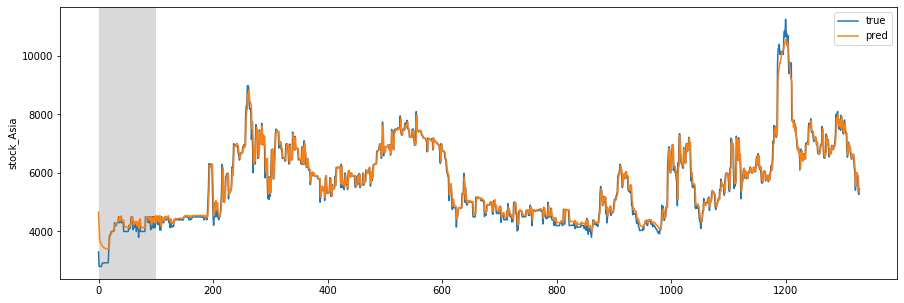

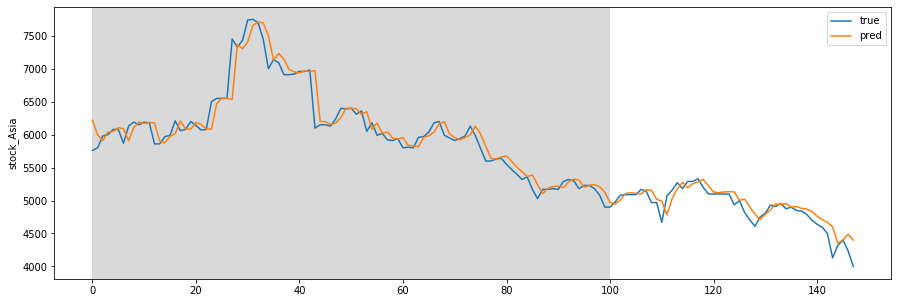

In [24]:
# stock_asia을 이용한 예측
plot_comparison(start_idx=0, length=len(y_train), train=True)
plot_comparison(start_idx=0, length=len(y_test), train=False)